<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter06/Road_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Road Sign Object Detection

In [16]:
# Import the needed packages
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torchsummary --break-system-packages


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --break-system-packages


In [18]:
# Download the data
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets 
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv

--2024-02-26 14:30:52--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv.1’

signnames.csv.1     100%[===================>]     999  --.-KB/s    in 0s      

2024-02-26 14:30:52 (144 MB/s) - ‘signnames.csv.1’ saved [999/999]



In [ ]:
# Unzip the data files in terminal using commented commands
#!unzip -qq GTSRB_Final_Training_Images.zip
#!unzip -qq GTSRB_Final_Test_Images.zip

In [31]:
# Remove the zip file to clean up
!rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

In [32]:
# Define the transformation pipeline on top of the image without augmentation.
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

In [33]:
# Convert each image into a PIL image, resize and crop from the center.
# Scale the image to have pixel values between 0 and 1 using .ToTensor.
# Normalize the input image so a pre-trained model can be leveraged.
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

In [34]:
# Create the training and validation datasets and dataloaders.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[02/26/24 15:00:20] INFO     29406                                                                                                                 ]8;id=311893;file:///tmp/ipykernel_165/2140838038.py:35\2140838038.py]8;;\:]8;id=320361;file:///tmp/ipykernel_165/2140838038.py:35#__init__:35\__init__:35]8;;\

                    INFO     9803                                                                                                                  ]8;id=17835;file:///tmp/ipykernel_165/2140838038.py:35\2140838038.py]8;;\:]8;id=919375;file:///tmp/ipykernel_165/2140838038.py:35#__init__:35\__init__:35]8;;\

In [35]:
# Define the model.
import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

In [36]:
# Define the functions to train and validate on a batch of data.
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

EPOCH: 1.000  trn_acc: 0.455  val_loss: 0.772  val_acc: 0.752  trn_loss: 1.862  (26.88s - 1048.25s remaining)
EPOCH: 2.000  trn_acc: 0.777  val_loss: 0.469  val_acc: 0.844  trn_loss: 0.700  (52.09s - 989.79s remaining)
EPOCH: 3.000  trn_acc: 0.837  val_loss: 0.381  val_acc: 0.873  trn_loss: 0.500  (77.24s - 952.65s remaining)
EPOCH: 4.000  trn_acc: 0.871  val_loss: 0.292  val_acc: 0.906  trn_loss: 0.398  (102.28s - 920.55s remaining)
EPOCH: 5.000  trn_acc: 0.887  val_loss: 0.268  val_acc: 0.908  trn_loss: 0.341  (127.53s - 892.70s remaining)
EPOCH: 6.000  trn_acc: 0.900  val_loss: 0.217  val_acc: 0.928  trn_loss: 0.303  (152.74s - 865.51s remaining)
EPOCH: 7.000  trn_acc: 0.911  val_loss: 0.219  val_acc: 0.924  trn_loss: 0.264  (177.95s - 838.92s remaining)
EPOCH: 8.000  trn_acc: 0.920  val_loss: 0.182  val_acc: 0.940  trn_loss: 0.247  (203.19s - 812.76s remaining)
EPOCH: 9.000  trn_acc: 0.925  val_loss: 0.187  val_acc: 0.938  trn_loss: 0.227  (228.55s - 787.22s remaining)
EPOCH: 10.00

100%|██████████| 141/141 [00:01<00:00, 96.34it/s] 


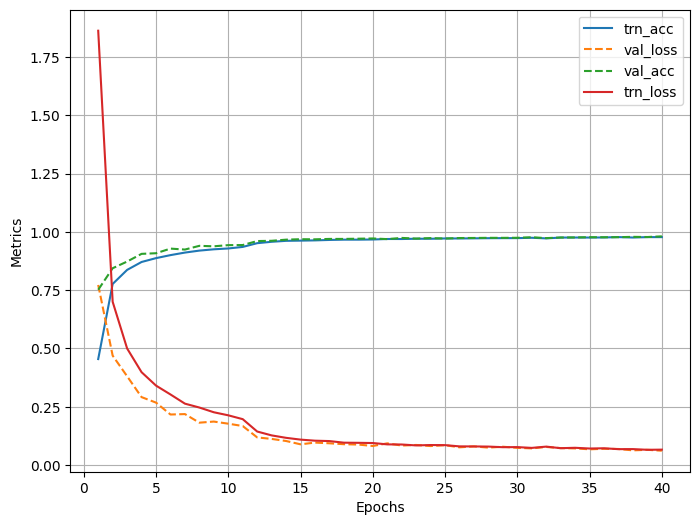

[02/26/24 15:18:13] INFO     Dumped object of size ≈2 MB @ "40-yes-aug-yes-bn.log" in 1.44e+00 seconds                                             ]8;id=630138;file:///tmp/ipykernel_165/2088580068.py:23\2088580068.py]8;;\:]8;id=776544;file:///tmp/ipykernel_165/2088580068.py:23#<module>:23\<module>:23]8;;\

» 40-yes-aug-yes-bn.log

In [37]:
# Define the model. Train over increasing epochs.
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, '40-yes-aug-yes-bn.log')